In [1]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline
  
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# the following cells will use the rai framework for robot control, simulation and motion planning
# https://github.com/MarcToussaint/rai
import sys
import os 
print(os.getcwd())
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../../ry/')
sys.path.append('../../')
sys.path.append('../')
import libry as ry
import time
import gc
import os
from collections import defaultdict
import utils

# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
os.environ["ROS_IP"] = "129.69.216.204"

/home/niklas/git/uni/robotics-course/practical/clean


/home/niklas/.local/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [3]:
"""

for camera1:
total ERROR = 0.00395552
total ERROR after radius correction = 0.00396736
*** total Pinv:
[0.00187839, 7.8914e-05, -0.614197, -0.048283,
 8.75529e-05, -0.00162767, 0.864538, 0.228542,
 5.11853e-05, -0.000906396, -0.676576, 1.78686]
*** camera intrinsics K:
[531.597, -6.16406, -313.788,
 0, -536.315, -243.297,
 0, 0, -0.989076]
*** camera world pos: [-0.048283, 0.228542, 1.78686]
*** camera world rot: [0.967548, 0.251242, -0.00732202, 0.0259533]
"""

cam_world_pos= [-0.048283, 0.228542, 1.78686]
cam_world_rot= [0.967548, 0.251242, -0.00732202, 0.0259533]

headCamIntrinsics = {'fx': 531.597 , 
                       'fy':  -536.315, 
                       'cx': -313.788, 
                       'cy': -243.297, 'width': 640, 'height':480}
pinv_head = np.array([
[0.00187839, 7.8914e-05, -0.614197, -0.048283],
 [8.75529e-05, -0.00162767, 0.864538, 0.228542],
 [5.11853e-05, -0.000906396, -0.676576, 1.78686]
])

In [5]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
gc.collect()
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../rai-robotModels/baxter/baxter_new.g')
cam = C.addObject(name="cam", parent="base_footprint", shape=ry.ST.sphere, size=[0.01], color=[0,1,0], pos=cam_world_pos, quat=cam_world_rot)
nodeName = "camMarc"

q_home = C.getJointState()
q_zero = q_home.copy() * 0.
B = C.operate(nodeName)
B.sync(C)
C.makeObjectsConvex()
B.sendToReal(False)

In [23]:
def check_target(targetFrame):
    if not targetFrame in C.getFrameNames():
        frame = C.addObject(name=targetFrame, parent="base_footprint" ,shape=ry.ST.sphere, size=[.01], pos=[0,0,0], color=[0.,0.,1.])
    return C.frame(targetFrame)

def close_gripper(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-2] = 0.04
    else:
        q[-2] = 0
    B.moveHard(q)

def plan_path(targetPos, angle, targetFrame, gripperFrame, steps, time):
    intermediatePos = cam_world_pos + 0.9 * (targetPos - cam_world_pos)
    intermediate = check_target("intermediate")
    target = check_target(targetFrame)
    rotA = utils.rotz(angle)
    rotC = utils.quat2rotm(cam_world_rot)
    rotM = rotA @ rotC
    B.sync(C)
    quat = utils.rotm2quat(rotM)
    target.setPosition(targetPos)
    intermediate.setPosition(intermediatePos)
    target.setQuaternion(quat)
    pp = C.komo_path(1, 30, 10, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductYZ, frames=[gripperFrame, targetFrame], target=[0], time=[.5, 1])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames= [gripperFrame, "cam"], target= [1], time= [.5, 1])
    #pp.addObjective(type= ry.OT.sos,feature= ry.FS.qItself, frames= [], target= q_home, time=[1.])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.distance, frames= [gripperFrame, 'intermediate'], target= [0], time= [.5])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= [gripperFrame, targetFrame], target=[0,0,-0.04],time= [1.])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself, frames= [], order= 1,  time= [0, 1])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

In [8]:
B.sendToReal(True)
B.moveHard(q_home)
close_gripper(False)

In [9]:
from webserver import sampleClient
import vision
import cv2
from skimage import measure, morphology

In [10]:
cam = ry.Camera("camMarc", "/camera/rgb/image_rect_color", "/camera/depth/image_rect_raw", True)

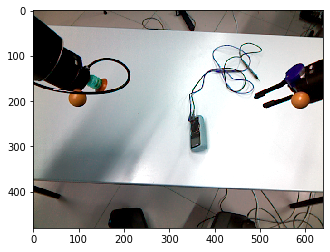

In [64]:
img = cam.getRgb()
d = cam.getDepth()
plt.imshow(img)

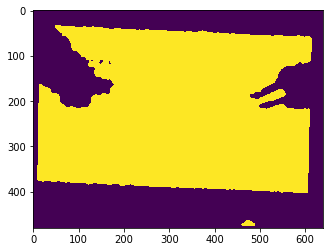

In [61]:
dm, m = vision.maskDepth(d, .92,1.3 )
m = cv2.medianBlur(m.astype(np.uint8), 5)
plt.imshow(m)

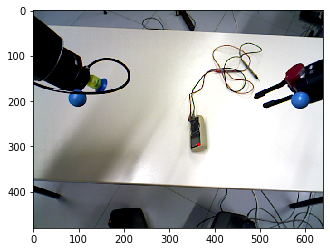

In [66]:
grasp = sampleClient.predictGQCNN(img, d, host="http://multitask.ddnss.de:5000", segmask=m, **headCamIntrinsics)
vision.plotCircleAroundCenter(img, grasp["x"], grasp["y"])

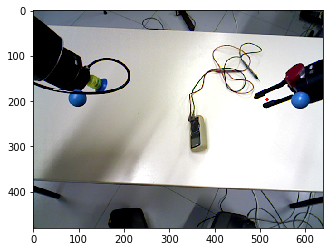

In [65]:
grasp = sampleClient.predictFCGQCNN(img, d, m,host="http://multitask.ddnss.de:5000", **headCamIntrinsics)
vision.plotCircleAroundCenter(img, grasp["x"], grasp["y"])

In [67]:
grasp_p, x, y = vision.getGraspPosition_noIntr(d,grasp["x"], grasp["y"])
x = pinv_head @ np.array(list(grasp_p) + [1])
steps = 30; time = 10
B.sendToReal(False)
B.moveHard(q_home)
p, pp = plan_path(x, grasp["angle"], "ball", "baxterR", steps, time)

In [68]:
B.sendToReal(True)
close_gripper(False)
B.move(p, [time/steps * i for i in range(len(p))], False)

In [42]:
close_gripper(True)

In [69]:
B.moveHard(q_home)

In [70]:
B.sendToReal(False)

In [343]:
B.sendToReal(True)